In [21]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from torchvision import *
import torch as pt
import numpy as np

In [22]:
data = np.load('mnist.npz')
mnist_x = data['train_data']
mnist_y = data['train_labels']

mnist_x_= data['test_data']
mnist_y_= data['test_labels'] 

In [23]:
mnist_full_x = np.concatenate([mnist_x, mnist_x_])
mnist_full_y = np.concatenate([mnist_y, mnist_y_])

# Data loaders

**hdd**

In [24]:
def HddLoad(dataset, split=1, batch_size=1,
                   t_trans=transforms.Compose([]), v_trans=transforms.Compose([]), device='cpu' ):
    from copy import copy                        # prepare_dataset(ptv.datasets.MNIST, 0.75, batch_size=64)
    data = dataset('./dataset_train/', train=True, transform=t_trans, download=True)
    data.train_labels=data.train_labels.to(device)
    
    length = int(split*len(data))
    train_data, valid_data = pt.utils.data.random_split(data, [length, len(data)-length])
    
    valid_data.dataset = copy(data)
    valid_data.transform = v_trans
    
    return {'train':pt.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True),
            'eval' :pt.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)}

**ram**

In [25]:
def RamLoad(dataset, labels, split=1, batch_size=1,
                   t_trans=transforms.Compose([]), v_trans=transforms.Compose([])):
    
    class RamLoader(pt.utils.data.DataLoader): 
        def __init__(self, data, labels, transform, **kwargs):
            super().__init__(pt.utils.data.TensorDataset(data,labels), **kwargs)
            self.dataset.transform = transform
    
    indices = pt.randperm(dataset.shape[0])
    split_point = int(split*dataset.shape[0])
    train_data = dataset[ indices[:split_point] ]; train_labels= labels[ indices[:split_point] ]
    valid_data = dataset[ indices[split_point:] ]; valid_labels= labels[ indices[split_point:] ]
    
    return {'train':RamLoader(train_data, train_labels, transform=t_trans, batch_size=batch_size, shuffle=True),
            'eval' :RamLoader(valid_data, valid_labels, transform=v_trans, batch_size=batch_size, shuffle=False)}

**defined transformation on data**

In [26]:
#################################
## DATA TRANSFORMS DEFINITIONS ##
#################################

class TransformDevice:
    def __init__(self, device):
        self.device = device
    def __call__(self, x):
        return x.to(self.device)
    
class TransformFlatten:
    def __call__(self, x):
        return x.view(x.shape[0], -1)
    
class TransformStandarize:
    def __init__(self, mean=0, std=1):
        self.mean, self.std = mean, std
    def __call__(self, x):
        return (x - pt.mean(x) + self.mean) / pt.std(x) * self.std
    
def ApplyTransforms(data, transforms):
    transformed = [transforms(x) for x in data]
    return pt.stack(transformed)

# Network code

In [27]:
import time

class LayerFlatten(pt.nn.Module):
    def forward(self, x): return x.view(x.shape[0], -1)
    
class LayerThicken(pt.nn.Module):
    def forward(self, x):
        if x.dim()==4:
            return x
        if x.dim()==3:
            return x[:,None,:,:]
        if x.dim()==2:
            n, m = x.shape
            return x[n, None, int(m**0.5), m-int(m**0.5)]

class NN:
    def __init__(self, model, device): # nn = NN(model, prepr, 'cpu')
        super().__init__()
        self.model = model.to(device)
        self.device = device
        self.epoch = 0
        
        # DEFAULTS
        self.optim = pt.optim.SGD(params=model.parameters(), lr=0.1)
        self.scheduler = pt.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.99)
    
    def fit(self, data_loader, loss, silent=False, s_report=100, v_report=1, max_epochs=float('inf'), loop_operation=[], epoch_operation=[]):
        try:
            if not silent:
                print("TRAINING:\n{:<10} | {:<10} | {:<12} - {}\n".format\
                      ('epoch', 'time', 'error rate', 'mistakes...'))
            
            i, result = 0, 0
            self.stime = time.time()
            eval_length = data_loader['eval'].dataset.__len__()
            history = {'train':{'i':[], 'e':[], 'l':[]}, 'eval':{'i':[], 'e':[]}}
            self.scheduler.last_epoch = self.epoch-1
            
            while True:
                self.scheduler.step()
                if not self.epoch % v_report:
                    res = self.evaluate(data_loader['eval'], eval_length, result, silent)
                    history['eval']['e'].append(float(res)); history['eval']['i'].append(i)
                    
                self.epoch+=1
                self.model.train()
                for op in epoch_operation: op(self.epoch) # You can run some additional, outside function running every epoch

                for x, y in data_loader['train']:
                    
                    for op in loop_operation: op() # You can run some additional, outside functions here running every iteration
                    i+=1
                    self.optim.zero_grad()
                    x = self.model.forward(x)
                    L = loss(x, y)
                    
                    L.backward()
                    with pt.no_grad():
                        self.optim.step()
                        result = pt.sum(pt.argmax(x, dim=-1)==y, dtype=pt.float)/x.shape[0]
                           
                    if not i%s_report:
                        history['train']['e'].append(float(100-100*result))
                        history['train']['l'].append(float(L)); history['train']['i'].append(i)
                        if not silent: self.report(i, L, result)
                        
                if self.epoch>=max_epochs: break
        except KeyboardInterrupt: pass
        
        if not silent:
            self.evaluate(data_loader['eval'], eval_length, result, silent)
            self.draw_history(history)
        return history
    
    def report(self, iteration, loss, error):
        print( "Iter {:>5} | err {:>5.2f}% | loss {:<5.3f}".format(iteration, 100-100*error, loss), end='\r' )
    
    def evaluate(self, data_loader, eval_length, train_error, silent=False):
        self.model.eval()
        with pt.no_grad():
            result = pt.tensor(0.)
            for x, y in data_loader:
                x = self.model.forward(x)
                predicts = pt.argmax(x, dim=-1)
                result += pt.sum(y==predicts)
        if not silent:
            print( "Epoch {:>4} | time {:0<5.3} | lr {:0<7.4} | tr {:>7.3f}% | eval {:>6.3f}% - {} mis".format( self.epoch,
                    time.time()-self.stime, self.optim.param_groups[0]['lr'],
                                                                100-100*train_error, 100-100*result/eval_length, int(eval_length-result)))
        self.stime = time.time()
        return 100 - 100*result/eval_length
        
    def predict(self, data, answers=None, silent=False):
        self.model.eval()
        with pt.no_grad():
            x = self.model.forward(data)
            x = pt.argmax(x, dim=-1)
        if answers is None: return x
        res = pt.sum(x==answers, dtype=pt.float) / x.shape[0]
        if not silent: print("Accuracy: {:>6.3f}%".format(100 * res))
        return float(res)
    
    def draw_history(self, history):
        print('\n'); plt.figure(figsize=(15,4)); plt.subplot(121)
        plt.plot(history['train']['i'], history['train']['l'])
        plt.xlabel('iterations'); plt.ylabel('training loss'); plt.grid(True, linewidth=0.2); plt.subplot(122)
        plt.plot(history['eval']['i'][1:], history['eval']['e'][1:], label='evaluation')
        plt.plot(history['train']['i'][1:], history['train']['e'][1:], label='training')
        plt.xlabel('iterations'); plt.ylabel('errors'); plt.grid(True, linewidth=0.2); plt.legend()

# Data loading

In [28]:
#########################################
## DATASET PREPROCESS AND AUGMENTATION ##
#########################################

DEVICE = 'cuda'
"""
t_trans = transforms.Compose([
    transforms.ToTensor(),
    TransformFlatten(),
    TransformDevice(DEVICE),
    TransformStandarize() ])

v_trans = transforms.Compose([
    transforms.ToTensor(),
    TransformFlatten(),
    TransformDevice(DEVICE),
    TransformStandarize() ])
HddLoader = HddLoad(datasets.MNIST, split=0.8, batch_size=128, t_trans=t_trans, v_trans=v_trans, device=DEVICE )
"""


tmnist_x = TransformStandarize()(pt.tensor(mnist_full_x, device=DEVICE, dtype=pt.float))
tmnist_y = pt.tensor(mnist_full_y, device=DEVICE, dtype=pt.long)

RamLoader = RamLoad(tmnist_x, tmnist_y, split=0.85, batch_size=128)

# Pruner

In [29]:
##########################
## NETWORK PRUNER CLASS ##
##########################
    
class Pruner:
    def __init__(self, model, loader=None, device='cpu', silent=False):
        self.device = device
        self.loader = loader
        self.model = model
        
        '''
        for i, layer in enumerate(model):
            try: layer.weight
            except AttributeError: continue
            self.weights.append(layer.weight)
            self.indicators.append(pt.ones_like(layer.weight).to(device))
        '''
            
        self.weights = list(model.parameters())
        self.indicators = [pt.ones_like(layer) for layer in model.parameters()]
        self.pruned = [0 for _ in range(len(self.indicators))]
 
        if not silent:
            print("number of weights to prune:", [x.numel() for x in self.indicators])

    def indicate(self):
        for weight, indicator in zip(self.weights, self.indicators):
            weight.data = weight * indicator

    def minmag(self, sparsity, silent=False): # prunes weights with smallest magnitude
        self.indicate()
        params = [weight.view(-1).abs().cpu() for weight in self.weights]
        if not isinstance(sparsity, list):
            params = [pt.cat(params)]
            sparsity = [sparsity]
        
        thresh = [ float( param.kthvalue( int(sparsity[i%len(sparsity)] * param.shape[0] + self.pruned[i] ) )[0] )
                                  for i, param in enumerate(params) ]
        
        for i, weight in enumerate(self.weights):
            self.indicators[i][weight.abs()<=thresh[i%len(thresh)]] = 0
            self.pruned[i] = int(pt.sum(self.indicators[i] == 0))
   
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])
            
        
    def minhess(self, sparsity, mini_batches=1, silent=False): # prunes with respect to hessians magnitude
        mini_batch=0
        self.indicate() # one forward pass
        self.model.zero_grad()
        grads2 = [pt.zeros_like(w) for w in self.weights]
        
        for x, y in self.loader:
            x = self.model.forward(x)
            L = pt.nn.CrossEntropyLoss()(x, y) # Loss
            temp_grads = pt.autograd.grad(L, self.weights, create_graph=True)
            f = sum([g.sum() for g in temp_grads]) # Second derivatives
            grads2 = [g+ag for g, ag in zip(grads2, pt.autograd.grad(f, self.weights))]
            mini_batch+=1
            if mini_batch>=mini_batches: break
        
        with pt.no_grad():
            saliences = pt.cat( [(g2 * w.pow(2)).view(-1).cpu() for w, g2 in zip(self.weights, grads2)] )
            thresh = float( saliences.kthvalue( int(sparsity * saliences.numel()) )[0] )
            for j, layer in enumerate(self.indicators):
                layer[ (grads2[j] * self.weights[j].pow(2)) <= thresh ] = 0
                self.pruned[j] = int(pt.sum(layer == 0))
        self.model.zero_grad()
        
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])

    
    def random(self, sparsity, silent=False): # prunes randomly
        for j, layer in enumerate(self.indicators):
            layer [ pt.rand_like(layer) <= sparsity ] = 0
            self.pruned[j] = int(pt.sum(layer == 0))
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])
            
    def snip(self, sparsity, mini_batches=1, silent=False): # prunes due to SNIP method
        mini_batch=0
        self.indicate()
        self.model.zero_grad()
        grads = [pt.zeros_like(w) for w in self.weights]
        
        for x, y in self.loader:
            x = self.model.forward(x)
            L = pt.nn.CrossEntropyLoss()(x, y)
            grads = [g.abs()+ag.abs() for g, ag in zip(grads, pt.autograd.grad(L, self.weights))]
            mini_batch+=1
            if mini_batch>=mini_batches: break

        with pt.no_grad():
            saliences = [(grad * weight).view(-1).abs().cpu() for weight, grad in zip(self.weights, grads)]
            if not isinstance(sparsity, list):
                saliences = [pt.cat(saliences)]
                sparsity = [sparsity] 
            thresh = [ float( sal.kthvalue( int(sparsity[i%len(sparsity)] * sal.shape[0] ) )[0] ) for i, sal in enumerate(saliences) ]
            
            for j, layer in enumerate(self.indicators):
                layer[ (grads[j] * self.weights[j]).abs() <= thresh[j%len(thresh)] ] = 0
                self.pruned[j] = int(pt.sum(layer == 0))
        self.model.zero_grad() 
        
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])
            
    def snip2(self, sparsity, mini_batches=1, silent=False): # prunes due to SNIP2 method
        mini_batch=0
        self.indicate() # one forward pass
        self.model.zero_grad()
        grads = [pt.zeros_like(w) for w in self.weights]
        grads2= [pt.zeros_like(w) for w in self.weights]
        
        for x, y in self.loader:
            x = self.model.forward(x)
            L = pt.nn.CrossEntropyLoss()(x, y) # Loss
            temp_grads = pt.autograd.grad(L, self.weights, create_graph=True)
            grads = [g+tg for g, tg in zip(grads, temp_grads)]
            f = sum([g.sum() for g in temp_grads]) # Second derivatives
            grads2 = [g+ag for g, ag in zip(grads2, pt.autograd.grad(f, self.weights))]
            mini_batch+=1
            if mini_batch>mini_batches: break
        
        with pt.no_grad():
            saliences = [(g * w - g2 * w.pow(2) / 2).view(-1).abs().cpu() for w, g, g2 in zip(self.weights, grads, grads2)]
            if not isinstance(sparsity, list):
                saliences = [pt.cat(saliences)]
                sparsity = [sparsity] 
            thresh = [ float( sal.kthvalue( int(sparsity[i%len(sparsity)] * sal.shape[0] ) )[0] ) for i, sal in enumerate(saliences) ]
            
            for j, layer in enumerate(self.indicators):
                layer[ (grads[j] * self.weights[j] - grads2[j] * self.weights[j].pow(2) / 2).abs() <= thresh[j%len(thresh)] ] = 0
                self.pruned[j] = int(pt.sum(layer == 0))
        self.model.zero_grad()
        
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])
            
            
    def snipR(self, sparsity, silent=False):
        with pt.no_grad():
            saliences = [pt.zeros_like(w) for w in self.weights]
            x, y = next(iter(self.loader))
            z = model.forward(x)
            L0 = pt.nn.CrossEntropyLoss()(z, y) # Loss

            for laynum, layer in enumerate(self.weights):
                if not silent: print("layer ", laynum, "...")
                for weight in range(layer.numel()):
                    temp = layer.view(-1)[weight].clone()
                    layer.view(-1)[weight] = 0

                    z = model.forward(x) # Forward pass
                    L = pt.nn.CrossEntropyLoss()(z, y) # Loss
                    saliences[laynum].view(-1)[weight] = (L-L0).abs()    
                    layer.view(-1)[weight] = temp
                
            saliences_bag = pt.cat([s.view(-1) for s in saliences]).cpu()
            thresh = float( saliences_bag.kthvalue( int(sparsity * saliences_bag.numel() ) )[0] )

            for j, layer in enumerate(self.indicators):
                layer[ saliences[j] <= thresh ] = 0
                self.pruned[j] = int(pt.sum(layer == 0))   
        
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])

# Grad2 tests

In [12]:
# UNIV GRADS

def nth_derivative(f, wrt, n):
    grads = []
    for i in range(n-1):
        grads.append( pt.autograd.grad(f, wrt, create_graph=True)[0] )
        f = sum([pt.sum(g) for g in grads])
    grads.append( pt.autograd.grad(f, wrt)[0] )
    return grads

x = pt.arange(4., requires_grad=True).reshape(2, 2)
loss = (x + (1-x**8)).sum()
print(nth_derivative(loss, x, 6))

[tensor([[ 1.0000e+00, -7.0000e+00],
        [-1.0230e+03, -1.7495e+04]], grad_fn=<AddBackward0>), tensor([[    -0.,    -56.],
        [ -3584., -40824.]], grad_fn=<MulBackward0>), tensor([[     -0.,    -392.],
        [ -14336., -122472.]], grad_fn=<AddBackward0>), tensor([[     -0.,   -2408.],
        [ -51968., -340200.]], grad_fn=<AddBackward0>), tensor([[     -0.,  -12824.],
        [-170240., -875448.]], grad_fn=<AddBackward0>), tensor([[      -0.,   -58520.],
        [ -503552., -2091096.]])]


# Models

In [13]:
def Simplest():
    model = pt.nn.Sequential(
        LayerFlatten(),
        pt.nn.Linear(784, 10, bias=False),
        pt.nn.LogSoftmax(dim=-1))
    return model

In [14]:
def ToyModel():
    model = pt.nn.Sequential(
        LayerFlatten(),
        pt.nn.Linear(784, 300),
        pt.nn.ReLU(),
        pt.nn.Linear(300, 10),
        pt.nn.LogSoftmax(dim=-1))
    return model

In [15]:
def LeNet5(init=None):
    model = pt.nn.Sequential( # 1, 28, 28
        LayerThicken(), 
        pt.nn.Conv2d(1, 6, kernel_size=5, padding=2), # 6, 28, 28
        pt.nn.ReLU(),
        pt.nn.MaxPool2d(kernel_size=2), # 6, 14, 14
        pt.nn.Conv2d(6, 16, kernel_size=5), # 16, 10, 10
        pt.nn.ReLU(),
        pt.nn.MaxPool2d(kernel_size=2), # 16, 5, 5
        LayerFlatten(),
        pt.nn.Linear(400,120),
        pt.nn.ReLU(),
        pt.nn.Linear(120, 84),
        pt.nn.ReLU(),
        pt.nn.Linear(84, 10),
        pt.nn.LogSoftmax(dim=-1))
    
    if init=='xavier':
        for layer in model:
            try: pt.nn.init.xavier_uniform_(layer.weight)
            except AttributeError: pass
            
    if init=='he':
        for layer in model:
            try: pt.nn.init.kaiming_uniform_(layer.weight)
            except AttributeError: pass
            
    return model

In [16]:
def LeNet_300_100():
    model = pt.nn.Sequential(
        LayerFlatten(),
        pt.nn.Linear(784, 300),
        #pt.nn.ReLU(),
        pt.nn.Linear(300, 100),
        #pt.nn.ReLU(),
        pt.nn.Linear(100, 10),
        pt.nn.LogSoftmax(dim=-1))
    return model

In [17]:
def vgg16():
    vgg = models.vgg16_bn()
    vgg.features[0] = pt.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    vgg.classifier = pt.nn.Sequential(
        pt.nn.Linear(512, 300),
        pt.nn.ReLU(),
        pt.nn.BatchNorm1d(300),
        pt.nn.Linear(300,10),
        pt.nn.LogSoftmax(dim=-1))
    model = pt.nn.Sequential( LayerThicken(), *vgg.features , LayerFlatten(), *vgg.classifier )
    return model

In [18]:
def resnet18():
    res = models.resnet18()

# Training

number of weights to prune: [150, 6, 2400, 16, 48000, 120, 10080, 84, 840, 10]
weights left:  [55, 2, 152, 2, 36, 2, 205, 27, 129, 8] sparsities:  [63.33, 66.67, 93.67, 87.5, 99.92, 98.33, 97.97, 67.86, 84.64, 20.0]
TRAINING:
epoch      | time       | error rate   - mistakes...

Epoch    0 | time 0.109 | lr 0.00120 | tr 100.000% | eval 89.914% - 9441 mis
Epoch    5 | time 6.510 | lr 0.00120 | tr  21.296% | eval 20.571% - 2160 mis
Epoch   10 | time 6.620 | lr 0.00120 | tr  11.111% | eval 18.371% - 1929 mis
Epoch   15 | time 6.640 | lr 0.00114 | tr  10.185% | eval 14.933% - 1568 mis
Epoch   20 | time 6.430 | lr 0.00114 | tr  10.185% | eval 15.524% - 1630 mis
Epoch   25 | time 6.380 | lr 0.00114 | tr  11.111% | eval 15.343% - 1611 mis
Epoch   30 | time 6.470 | lr 0.001083 | tr  16.667% | eval 15.943% - 1674 mis
Epoch   35 | time 6.460 | lr 0.001083 | tr  13.889% | eval 14.171% - 1488 mis
Epoch   40 | time 6.390 | lr 0.001083 | tr  13.889% | eval 15.457% - 1623 mis
Epoch   45 | time 6.480 

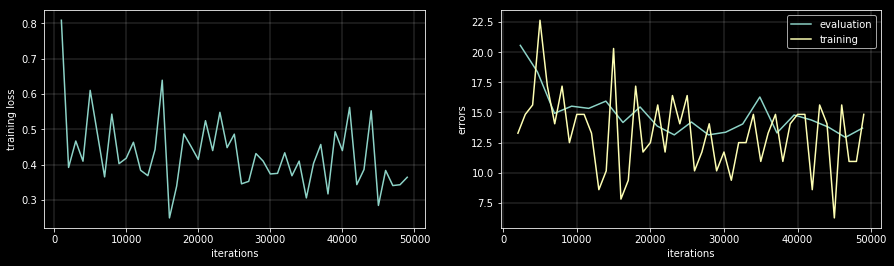

In [20]:
######################
## NETWORK TRAINING ##
######################
model = LeNet5()
nn = NN(model, DEVICE)

prune = Pruner(model, RamLoader['train'], DEVICE, silent=False)
prune.snip(0.9)

# for layer in model:
#     try: pt.nn.init.normal_(layer.weight, 0, 0.1)
#     except: pass

# model = LeNet5()
# nn = NN(model, DEVICE)
# prune.weights = list(model.parameters()) # resetrs parameters after pruning

#epoch_operation=[]
loop_operation=[prune.indicate]

nn.optim = pt.optim.Adam(model.parameters(), lr = 0.0012)
nn.scheduler = pt.optim.lr_scheduler.StepLR(nn.optim, step_size=15, gamma=0.95)

hist = nn.fit( RamLoader, pt.nn.CrossEntropyLoss(), s_report=1000, v_report=5, max_epochs=1000, silent=False,
                                              loop_operation=loop_operation)

In [27]:
tmnist_x_ = TransformStandarize()(pt.tensor(mnist_x_, device=DEVICE, dtype=pt.float))
tmnist_y_ = pt.tensor(mnist_y_, device=DEVICE)
# DENSE
nn.predict(tmnist_x_, tmnist_y_)

Accuracy: 98.320%


0.983199954032898

# LOSS FUNCTION PLOTTING

In [87]:
def LeNet_300_100():
    model = pt.nn.Sequential(
        LayerFlatten(),
        pt.nn.Linear(784, 300),
        pt.nn.Sigmoid(),
        pt.nn.Linear(300, 100),
        pt.nn.Sigmoid(),
        pt.nn.Linear(100, 10),
        pt.nn.LogSoftmax(dim=-1))
    return model

In [88]:
plt.rc('axes.formatter', useoffset=False)
plt.style.use('classic')

In [89]:
x, y = iter(RamLoader['train']).__next__()

In [90]:
DEVICE='cuda'
model = LeNet5()
nn = NN(model, DEVICE)
params = list(model.parameters())

In [91]:
loss = pt.nn.CrossEntropyLoss()

In [92]:
model.zero_grad()
z = model.forward(x)
starting_L = loss(z, y) # Loss
grads = pt.autograd.grad(starting_L, model.parameters(), create_graph=True)
f = sum([g.sum() for g in grads]) # Second derivatives
grads2 = pt.autograd.grad(f, model.parameters(), create_graph=True)
f = sum([g.sum() for g in grads2]) # Third derivatives
grads3 = pt.autograd.grad(f, model.parameters())

xspace = pt.linspace(0,1,10)

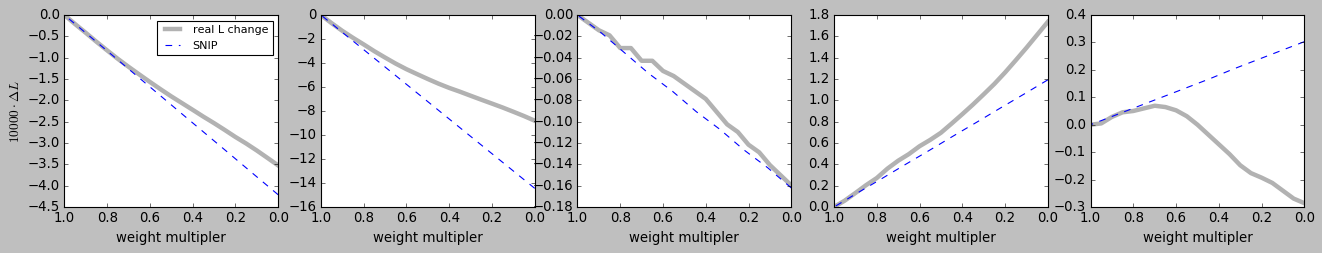

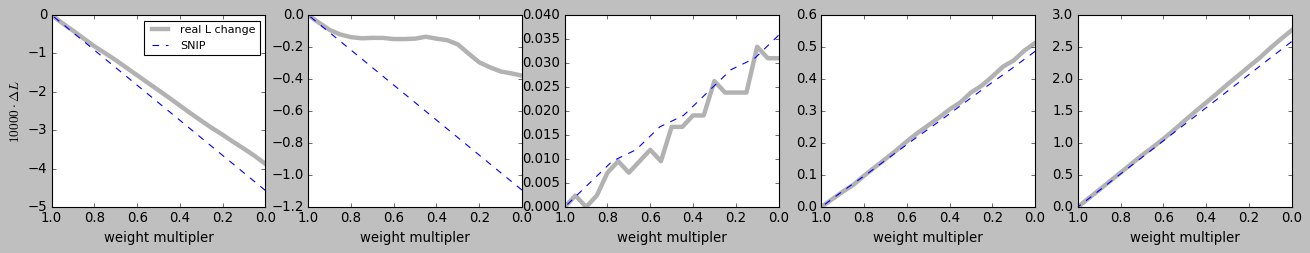

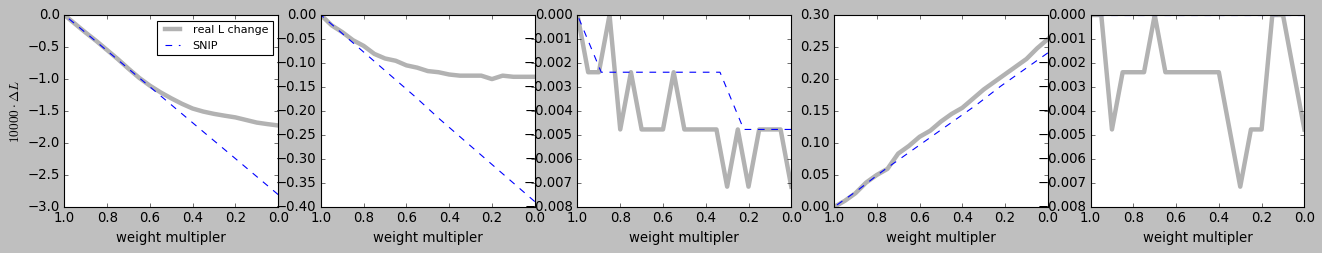

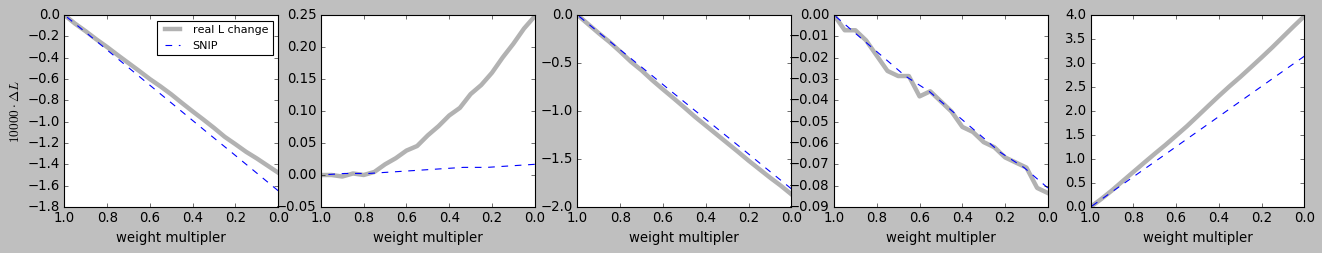

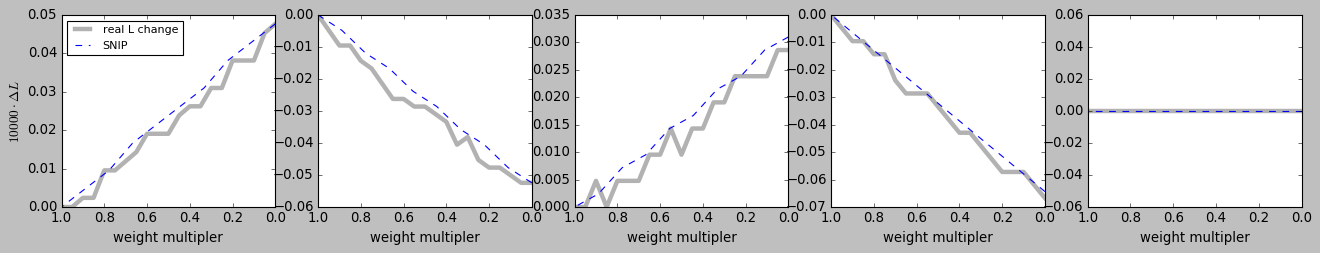

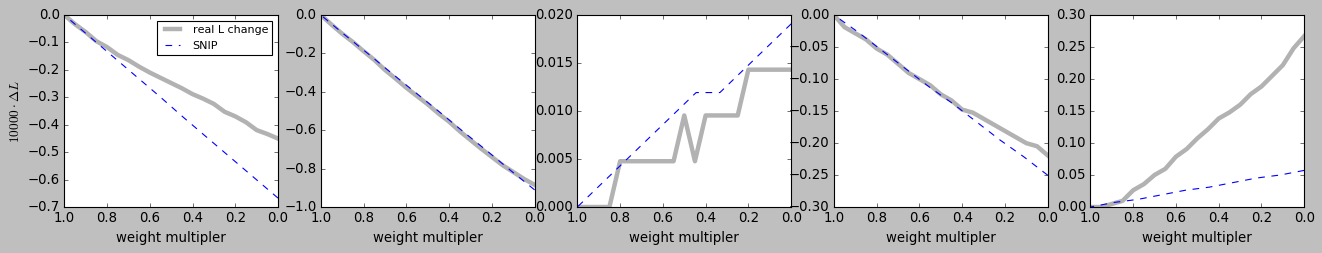

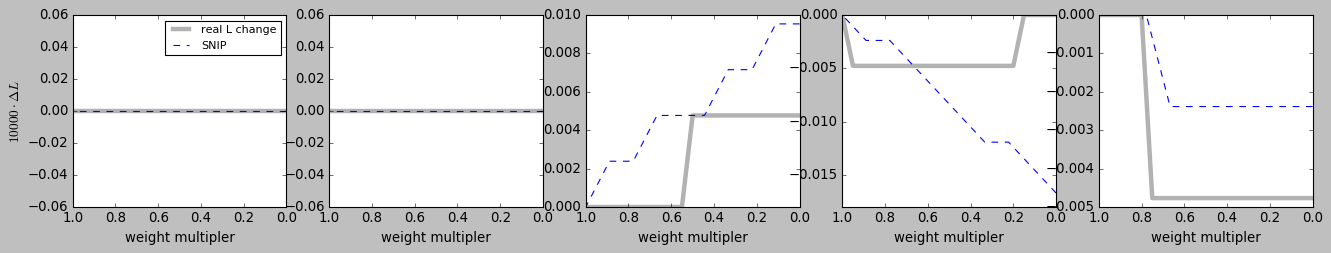

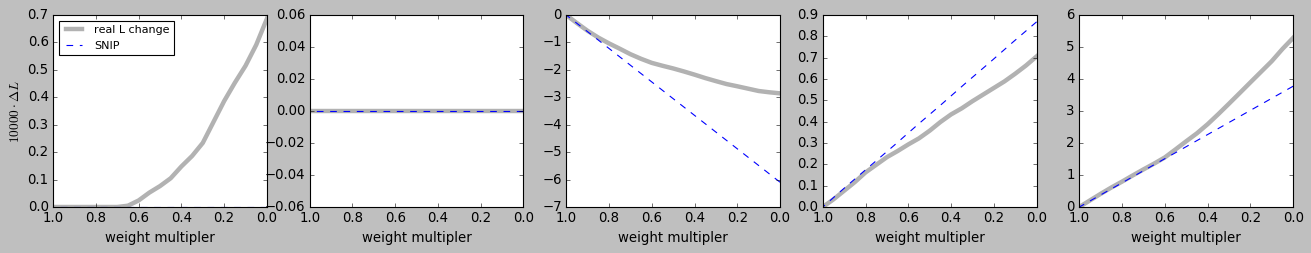

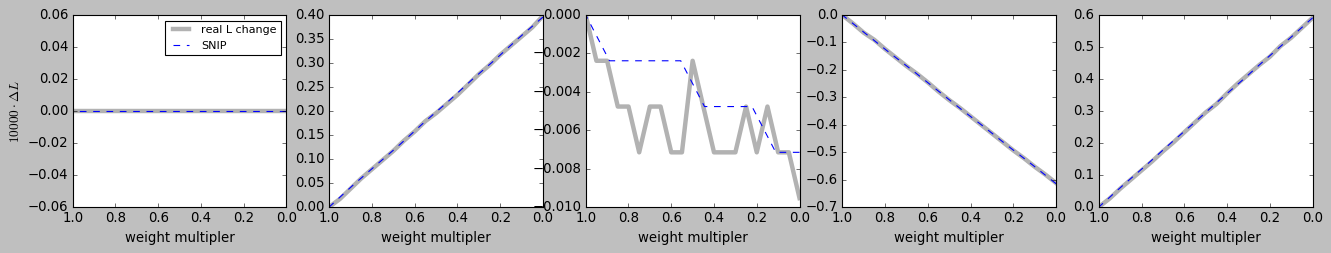

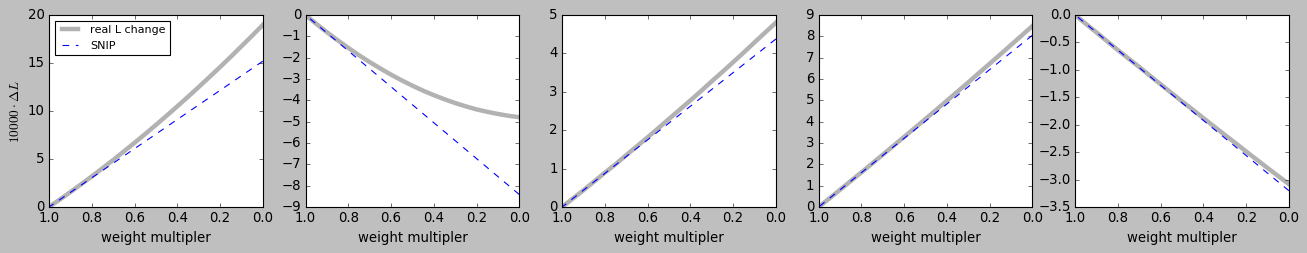

In [93]:
for layer_nr, layer in enumerate(params):
    fig = plt.figure(figsize=(20,3))
    
    for i, param_nr in enumerate(pt.linspace(0, layer.numel()-1, 5)):
        param_nr = param_nr.to(pt.long)
        losses_hist = []
        multiplers = []
        
        # calculates line from beforehand calculated grads
        w0 = layer.view(-1)[param_nr]
        xs = layer.view(-1)[param_nr] * xspace
        g1 = grads[layer_nr].view(-1)[param_nr]
        g2 = grads2[layer_nr].view(-1)[param_nr]
        g3 = grads3[layer_nr].view(-1)[param_nr]
        
        ### SNIP^1 COFICIENTS
        a = g1
        b = starting_L - g1 * w0
        plot1 = a * xs + b
        ### SNIP^1 DONE

        ### SNIP^2 COFICIENTS
        a = g2 / 2
        b = g1 - 2 * a * w0
        c = starting_L - a * w0**2 - b * w0
        plot2 = a * xs**2 + b * xs + c
        ### SNIP^2 DONE
        
        ### SNIP^3 COFICIENTS
        a = g3 / 6
        b = g2 / 2 - 3 * a * w0
        c = g1 - 3 * a * w0**2 - 2 * b * w0
        d = starting_L - a * w0**3 - b * w0**2 - c * w0
        plot3 = a * xs**3 + b * xs**2 + c * xs + d
        ### SNIP^3 DONE
        
        ### SNIP^3 COFICIENTS
        a = (g1 * pt.exp(starting_L))# / (1 + g1 * w0 - g1 * xs)
        b = pt.exp(starting_L) - a * w0
        plot4 = pt.log(a * xs + b)
        ### SNIP^3 DONE

        start_value = layer.view(-1)[param_nr].clone()
        
        for w in pt.arange(1.,-0.01,-0.05):    
            layer.view(-1)[param_nr] = start_value * w 
            model.zero_grad()
            z = model.forward(x)
            L = loss(z, y) # Loss
            losses_hist.append( (L-starting_L)*1e4 )
            multiplers.append(w)
        layer.view(-1)[param_nr] = start_value
        
        plt.subplot(1,5,i+1)
        plt.plot(multiplers, losses_hist, label='real L change', linewidth=4, color='black', alpha=0.3)
        plt.plot(list(xspace), list( (plot1-starting_L)*1e4 ), color='blue', label='SNIP', linestyle='dashed')
        #plt.plot(list(xspace), list( (plot2-starting_L)*1e4 ), color='orange', label='SNIP$^2$', linestyle='dashed')
        #plt.plot(list(xspace), list( (plot3-starting_L)*1e4 ), color='green', label='SNIP$^3$', linestyle='dashed')
        #plt.plot(list(xspace), list( (plot4-starting_L)*1e4 ), color='black', label='SNIP$^s$', linestyle='dashed')
        plt.xlim([0,1][::-1])
        plt.xlabel('weight multipler')
        if i==0: plt.ylabel('$10000\cdot\Delta L$'); plt.legend(fontsize=10, loc=0)

# Night Tests Code

In [267]:
def NetworkCreation(typ, sparsity, method):
    model = typ()
    nn = NN(model, DEVICE)
    
    prune = Pruner(model, RamLoader['train'], DEVICE, silent=True)
    if method=='snip': prune.snip (sparsity, silent=True)
    if method=='snip2': prune.snip2(sparsity, silent=True)
    if method=='snipR': prune.snipR(sparsity, silent=True)
    if method=='rand': prune.random(sparsity, silent=True)
    if method=='hess': prune.minhess(sparsity, silent=True)
    if method=='minmag': prune.minmag(sparsity, silent=True)
    loop_operation=[prune.indicate]
    
    nn.optim = pt.optim.Adam(model.parameters(), lr = 0.0012)
    nn.scheduler = pt.optim.lr_scheduler.StepLR(nn.optim, step_size=15, gamma=0.95)
    
    return nn, loop_operation

In [ ]:
types = ['snip', 'snipR', 'snip2', 'hess', 'rand', 'minmag']
history = {'snip':[], 'snipR':[], 'snip2':[], 'hess':[], 'rand':[], 'minmag':[]}

import time
start = time.time()

typ = LeNet5
repetitions = 20

for sparsity in np.arange(0.05, 0.96, 0.05):
    for type_ in types:
        for rep in range(repetitions):
        
            print("sparsity: {:<4.2f}, method: {}, rep: {}, time: {}, error rate: ".format(sparsity, type_,
                                                                                              rep, int(time.time() - start), end=''))
            nn, loop_op = NetworkCreation(typ, sparsity, type_)
            hist = nn.fit( RamLoader, pt.nn.CrossEntropyLoss(), s_report=float('inf'), v_report=1, max_epochs=100, silent=True,
                                                                                              loop_operation=loop_op)
            acc = min( hist['eval']['e'] )
            history[type_].append( [sparsity, acc] )
            print(acc)

import pickle
with open('RESULTS.pkl', 'wb') as f:
    pickle.dump([history], f)
f.close()

sparsity: 0.05, method: snip, rep: 0, time: 0, error rate: 


# Histrograms of weights

number of weights to prune: [235200, 300, 30000, 100, 1000, 10]
weights left:  [14435, 1, 11337, 40, 839, 9] sparsities:  [93.86, 99.67, 62.21, 60.0, 16.1, 10.0]


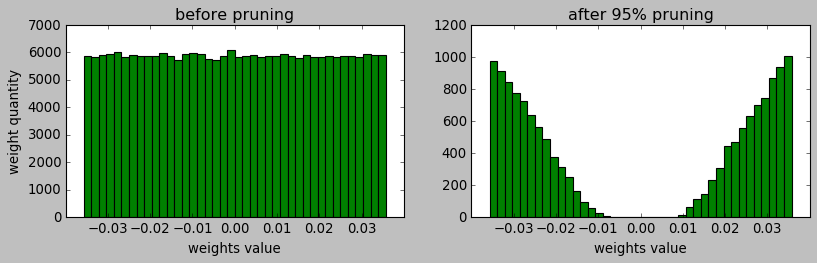

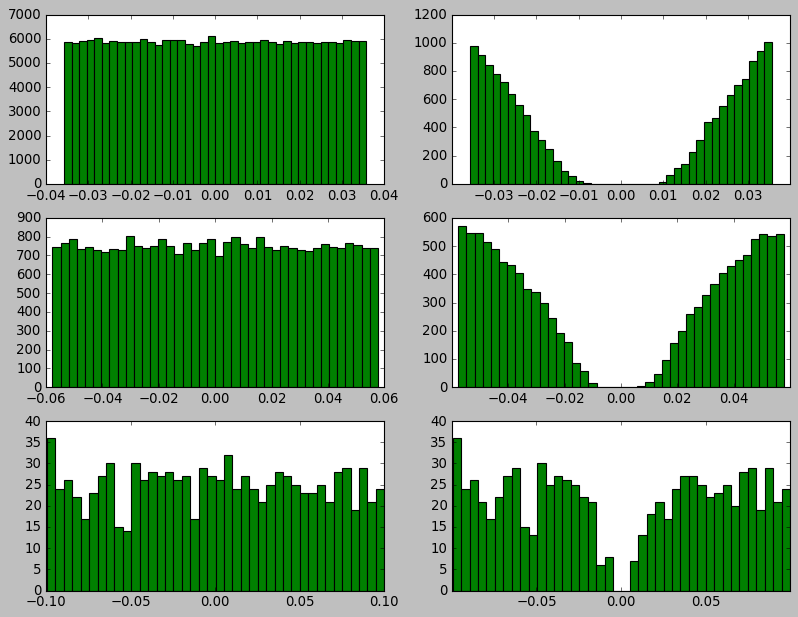

In [86]:
model = LeNet_300_100()
# for layer in model:
#     try:
#         pt.nn.init.xavier_normal_(layer.weight)
#     except: pass
nn = NN(model, DEVICE)
prune = Pruner(model, RamLoader['train'], DEVICE, silent=False)
prune.snip(0.9)

selected_layer = 0

fig1 = plt.figure(figsize=(12, 3))

plt.subplot(len(prune.weights)/2, 2, 1)
plt.title("value", fontsize=13)
plt.ylabel("quantity")

plt.subplot(1, 2, 1)
plt.hist(prune.weights[selected_layer].view(-1).detach().cpu(), bins=40, color='green')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1])
plt.title("before pruning")
plt.ylabel("weight quantity")
plt.xlabel("weights value")

fig2 = plt.figure(figsize=(12,len(prune.weights)*1.5))
for layer in range(0, len(prune.weights), 2):   
    plt.subplot(len(prune.weights)/2, 2, layer+1)
    plt.hist(prune.weights[layer].view(-1).detach().cpu(), bins=40, color='green')

    #ylim = plt.ylim()

prune.indicate()
plt.figure(fig1.number)
plt.subplot(1, 2, 2)
plt.hist(prune.weights[selected_layer][prune.weights[selected_layer]!=0].view(-1).detach().cpu(), bins=40, color='green')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1])
plt.title("after 95% pruning")
plt.xlabel("weights value")
plt.figure(fig2.number)

for layer in range(0, len(prune.weights), 2):
    plt.subplot(len(prune.weights)/2, 2, layer+2)
    plt.hist(prune.weights[layer][prune.weights[layer]!=0].view(-1).detach().cpu(), bins=40, color='green')
    locs, labels = plt.xticks()
    plt.xticks(locs[1:-1])
    #plt.ylim(ylim)